# Neural Networks and Deep Learning- Project

## Context:
A Recognising multi-digit numbers in photographs captured at street level is an important component of modern-day map making. A classic example of a corpus of such street-level photographs is Google’s Street View imagery composed of hundreds of millions of geo-located 360-degree panoramic images.

The ability to automatically transcribe an address number from a geo-located patch of pixels and associate the transcribed number with a known street address helps pinpoint, with a high degree of accuracy, the location of the building it represents. More broadly, recognising numbers in photographs is a problem of interest to the optical character recognition community.

While OCR on constrained domains like document processing is well studied, arbitrary multi-character text recognition in photographs is still highly challenging. This difficulty arises due to the wide variability in the visual appearance of text in the wild on account of a large range of fonts, colours, styles, orientations, and character arrangements.

The recognition problem is further complicated by environmental factors such as lighting, shadows, specularity, and occlusions as well as by image acquisition factors such as resolution, motion, and focus blurs. In this project, we will use the dataset with images centred around a single digit (many of the images do contain some distractors at the sides). Although we are taking a sample of the data which is simpler, it is more complex than MNIST because of the distractors.

## Data Description:
The SVHN is a real-world image dataset for developing machine learning and object
recognition algorithms with the minimal requirement on data formatting but comes from a significantly harder,
unsolved, real-world problem (recognising digits and numbers in natural scene images). SVHN is obtained from
house numbers in Google Street View images. Where the labels for each of this image are the prominent number in that image i.e. 2,6,7 and 4 respectively.
The dataset has been provided in the form of h5py files.

## Project Objective:
We will build a digit classifier on the SVHN (Street View Housing Number) dataset.

## Import Libraries

In [ ]:
%tensorflow_version 2.x

In [ ]:
from google.colab import drive
drive.mount('/drive')

Mounted at /drive


In [ ]:
import tensorflow as tf
import numpy as np
import h5py
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras import utils
from tensorflow.keras.utils import plot_model
from sklearn.preprocessing import MinMaxScaler, LabelBinarizer
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix,classification_report, roc_auc_score, roc_curve
from tensorflow.keras.layers import LeakyReLU

In [ ]:
print(tf.__version__)

2.4.1


In [ ]:
np.random.seed(1)

## Import the Dataset

In [ ]:
# Read the data from .h5 file
hf = h5py.File('/drive/MyDrive/Autonomous_Vehicles_SVHN_single_grey1.h5', 'r')
hf

<HDF5 file "Autonomous_Vehicles_SVHN_single_grey1.h5" (mode r)>

In [ ]:
# Get the keys
hf.keys()

<KeysViewHDF5 ['X_test', 'X_train', 'X_val', 'y_test', 'y_train', 'y_val']>

In [ ]:
# Load the already splited train, validation and test set
X_train = hf['X_train'][:]
y_train = hf['y_train'][:]

X_test = hf['X_test'][:]
y_test = hf['y_test'][:]

X_val = hf['X_val'][:]
y_val = hf['y_val'][:]

In [ ]:
print("Shape of X_train:", X_train.shape)
print("Shape of y_train:", y_train.shape)
print("Shape of X_test:", X_test.shape)
print("Shape of y_test:", y_test.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of y_val:", y_val.shape)

Shape of X_train: (42000, 32, 32)
Shape of y_train: (42000,)
Shape of X_test: (18000, 32, 32)
Shape of y_test: (18000,)
Shape of X_val: (60000, 32, 32)
Shape of y_val: (60000,)


<b>Observation:</b>
- There are 42000 records in training set with matrix size of 32x32 (i.e) image size of 32x32.
- 18000 records with matrix size of 32x32 in test set. 
- 60000 records with matrix size of 32x32 in validation set.
- y_train, y_test and y_val are contain label for given image matrix.

## Visualization

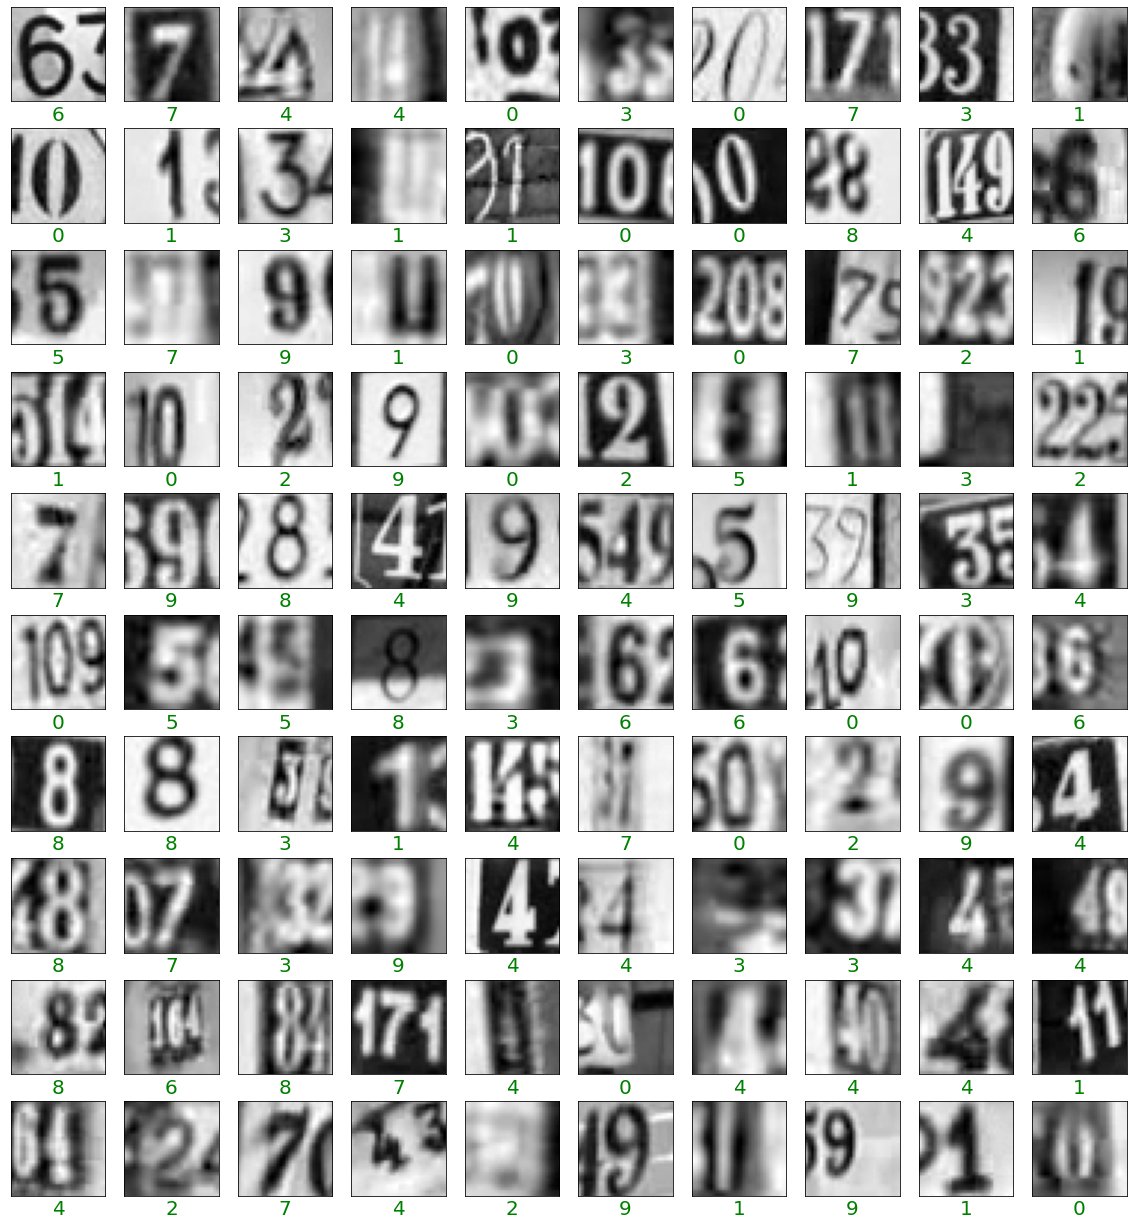

In [ ]:
# Plot the sample images
columns=10
rows=10

fig=plt.figure(figsize=(20, 22))

for i in range(1,columns*rows+1):
    img=X_train[i]
    fig.add_subplot(rows,columns,i)
    plt.xticks([])
    plt.yticks([])
    plt.xlabel(y_train[i] , color = 'green',fontsize = 20)
    plt.imshow(img,cmap='gray')

plt.show()

<b>Observation:</b>
- Some of the images are having noise and there are partial view of some digits (Ex: We can see digit 3 partially in first image.)
- Some of the images are very blurry. 

In [ ]:
# Define the funcation to plot the images randomly
def show_random_examples(x,y,p):
    indices = np.random.choice(range(x.shape[0]),10,replace = False)
  
    x = x[indices]
    y = y[indices]
    p = p[indices]
    x = x.reshape(x.shape[0],32,32)
  
    plt.figure(figsize=(10,5))
    for i in range(10):
        plt.subplot(2,5,1+i)
        plt.imshow(x[i],cmap = 'gray')
        plt.xticks([])
        plt.yticks([])
        col = 'green' if y[i] == p[i] else 'red'
        plt.xlabel(p[i] , color = col,fontsize = 20)
    plt.show()

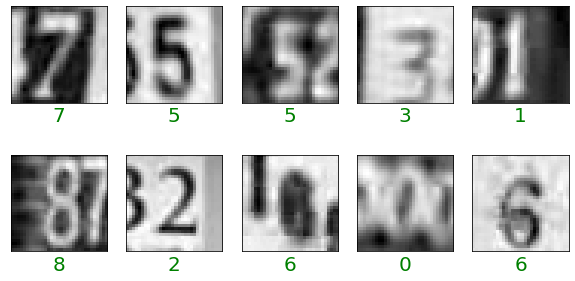

In [ ]:
# In training set, plot the sample images randomly
show_random_examples(X_train, y_train, y_train)

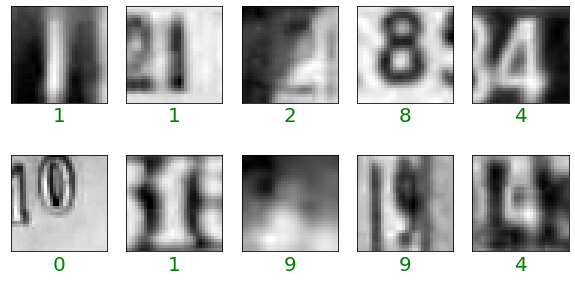

In [ ]:
# In test set, plot the sample images randomly
show_random_examples(X_test, y_test, y_test)

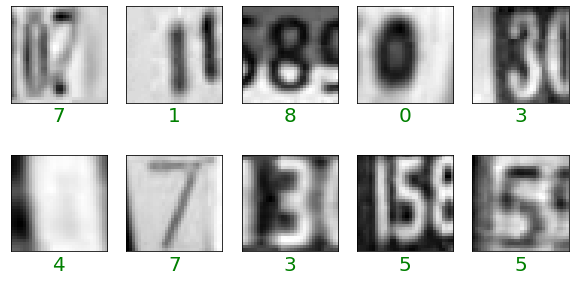

In [ ]:
# In validation set, plot the sample images randomly
show_random_examples(X_val, y_val, y_val)

<b>Observation:</b>
- There are some images very blurry. 
- Thus we can conclude there are lots of noise in data images


In [ ]:
# Check unique values in y_train
np.unique(y_train)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
# Check unique values in y_val
np.unique(y_val)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

In [ ]:
# Check unique values in y_test
np.unique(y_test)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

**Observation:** There are 10 classes in y_train, y_test and y_val. 

## Preprocessing

### Reshape

In [ ]:
# Convert from 2D to 1D
X_train = X_train.reshape(X_train.shape[0], 32*32)
X_val = X_val.reshape(X_val.shape[0], 32*32)
X_test = X_test.reshape(X_test.shape[0], 32*32)

print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)

Shape of X_train: (42000, 1024)
Shape of X_val: (60000, 1024)
Shape of X_test: (18000, 1024)


**Observation:**
- After reshape, there are 1024 features in train, validation and test set.

In [ ]:
# Convert data type into float32 as GPU supports float32. 
X_train = X_train.astype('float32')
X_val = X_val.astype('float32')
X_test = X_test.astype('float32')

### Normalize the value 

In [ ]:
print('Before Normalization')
print('Minimum value of X_train', X_train.min())
print('Minimum value of X_train', X_train.max())
print('Minimum value of X_val', X_val.min())
print('Minimum value of X_val', X_val.max())
print('Minimum value of X_test', X_test.min())
print('Minimum value of X_test', X_test.max())

maxVal=X_train.max()
scaledXtrain = X_train/maxVal
scaledXval= X_val/maxVal
scaledXtest = X_test/maxVal

print('')
print('After Normalization')
print('Minimum value of X_train', scaledXtrain.min())
print('Minimum value of X_train', scaledXtrain.max())
print('Minimum value of X_val', scaledXval.min())
print('Minimum value of X_val', scaledXval.max())
print('Minimum value of X_test', scaledXtest.min())
print('Minimum value of X_test', scaledXtest.max())

Before Normalization
Minimum value of X_train 0.0
Minimum value of X_train 254.9745
Minimum value of X_val 0.0
Minimum value of X_val 254.9745
Minimum value of X_test 0.0
Minimum value of X_test 254.9745

After Normalization
Minimum value of X_train 0.0
Minimum value of X_train 1.0
Minimum value of X_val 0.0
Minimum value of X_val 1.0
Minimum value of X_test 0.0
Minimum value of X_test 1.0


### Onehot Encoding

In [ ]:
print('Sample value of y_train before OneHot Encode:', y_train[0])
print('Sample value of y_val before OneHot Encode:', y_val[0])
print('Sample value of y_test before OneHot Encode:', y_test[0])

# Apply OneHot Encoding for y_train, y_val and y_test
y_train = tf.keras.utils.to_categorical(y_train,num_classes=10)
y_val = tf.keras.utils.to_categorical(y_val,num_classes=10)
y_test = tf.keras.utils.to_categorical(y_test,num_classes=10)

print('')
print('Sample value of y_train after OneHot Encode:', y_train[0])
print('Sample value of y_val after OneHot Encode:', y_val[0])
print('Sample value of y_test after OneHot Encode:', y_test[0])

Sample value of y_train before OneHot Encode: 2
Sample value of y_val before OneHot Encode: 0
Sample value of y_test before OneHot Encode: 1

Sample value of y_train after OneHot Encode: [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
Sample value of y_val after OneHot Encode: [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
Sample value of y_test after OneHot Encode: [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


## Model Building

### Base Model

In [ ]:
# Initialize the model
model = tf.keras.Sequential()

# Add input layer
model.add(tf.keras.Input(shape=(1024)))

# Initilaize the weights
initializer = tf.keras.initializers.HeUniform(seed=7)

# Add hidden layers with Relu activation funcation
model.add(Dense(400,activation='relu', kernel_initializer=initializer))
model.add(Dense(200,activation='relu'))
model.add(Dense(100,activation='relu'))

# Add output layers with Softmax activiation funcation since it is multiclass classification
model.add(Dense(10,activation='softmax'))


In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 400)               410000    
_________________________________________________________________
dense_1 (Dense)              (None, 200)               80200     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               20100     
_________________________________________________________________
dense_3 (Dense)              (None, 10)                1010      
Total params: 511,310
Trainable params: 511,310
Non-trainable params: 0
_________________________________________________________________


**Observation:**

Formula: (output_size * input_size) + bias == number_parameters<br>
In first layer, (400 output * 1024 inputs) + 400 bias = 410000 Param<br>
In second layer, (200 output * 400 inputs) + 200 bias = 80200 Param<br>
In third layer, (100 output * 200 inputs) + 100 bias = 20100 Param<br>
In fourth layer, (10 output * 100 inputs) + 10 bias = 1010 Param

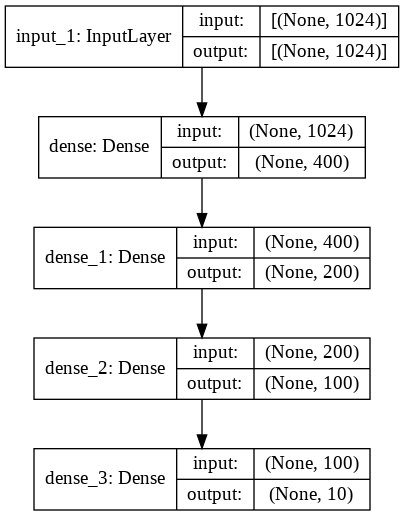

In [ ]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [ ]:
#Compile the model using categorical_crossentroy loss function as it is multiclass classification
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10,  restore_best_weights=True, mode='min')
history = model.fit(scaledXtrain, y_train,
          validation_data=(scaledXval, y_val), 
          epochs=100,
          batch_size = 128,
          verbose=1,
          callbacks= [callback]
         )

Epoch 1/100
329/329 [==============================] - 6s 10ms/step - loss: 2.2948 - accuracy: 0.1243 - val_loss: 1.7843 - val_accuracy: 0.3635
Epoch 2/100
329/329 [==============================] - 3s 8ms/step - loss: 1.5453 - accuracy: 0.4708 - val_loss: 1.2194 - val_accuracy: 0.6150
Epoch 3/100
329/329 [==============================] - 3s 8ms/step - loss: 1.2124 - accuracy: 0.6110 - val_loss: 1.1489 - val_accuracy: 0.6316
Epoch 4/100
329/329 [==============================] - 3s 8ms/step - loss: 1.0965 - accuracy: 0.6556 - val_loss: 1.1099 - val_accuracy: 0.6407
Epoch 5/100
329/329 [==============================] - 3s 8ms/step - loss: 1.0263 - accuracy: 0.6777 - val_loss: 0.9583 - val_accuracy: 0.7033
Epoch 6/100
329/329 [==============================] - 3s 8ms/step - loss: 0.9283 - accuracy: 0.7111 - val_loss: 0.9590 - val_accuracy: 0.7037
Epoch 7/100
329/329 [==============================] - 3s 8ms/step - loss: 0.8843 - accuracy: 0.7245 - val_loss: 0.8693 - val_accuracy: 0.726

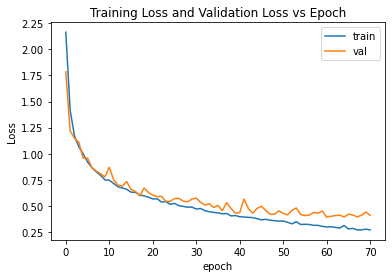

In [ ]:
# Plot the loss of training and validation against epoch
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss and Validation Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Above graph Loss vs Epoch shows that Loss of validation set is higher than loss of training set in 63 epoch.

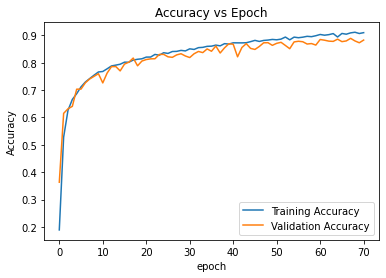

In [ ]:
# Plot the accuracy of training and validation against epoch
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
plt.show()

Above graph Accuracy vs Epoch shows that accuracy of training set is higher than accuracy of validation set. It shows that this model slightly overfit model. 

In [ ]:
model_name = []
train_score = []
train_loss = []

# Evaluate the model for training set
model_train_score = model.evaluate(scaledXtrain,y_train)

model_name.append('Base Model')
train_score.append(model_train_score[1])
train_loss.append(model_train_score[0])


1313/1313 [==============================] - 4s 3ms/step - loss: 0.2745 - accuracy: 0.9099


In [ ]:
val_score = []
val_loss = []

# Evaluate the model for validation set
model_val_score = model.evaluate(scaledXval,y_val)

val_score.append(model_val_score[1])
val_loss.append(model_val_score[0])

1875/1875 [==============================] - 5s 3ms/step - loss: 0.3940 - accuracy: 0.8849


In [ ]:
test_score = []
test_loss = []

# Evaluate the model for test set
model_test_score = model.evaluate(scaledXtest,y_test)

test_score.append(model_test_score[1])
test_loss.append(model_test_score[0])

563/563 [==============================] - 2s 3ms/step - loss: 0.6729 - accuracy: 0.8264


In [ ]:
# Predict the class for test set
preds = model.predict(scaledXtest)

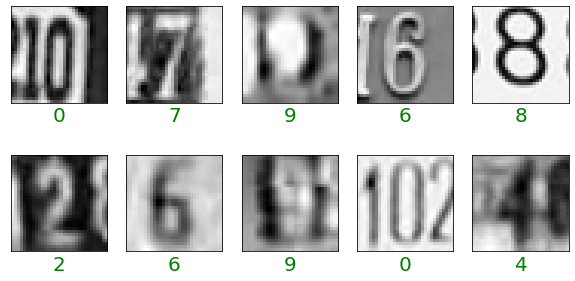

In [ ]:
# Plot the predicted class randomly
show_random_examples(scaledXtest,y_test.argmax(axis = 1),preds.argmax(axis = 1))

In [ ]:
prediction_clf = (preds > 0.5)
print(classification_report(y_test, prediction_clf))

              precision    recall  f1-score   support

           0       0.93      0.80      0.86      1814
           1       0.90      0.78      0.83      1828
           2       0.91      0.80      0.85      1803
           3       0.84      0.76      0.80      1719
           4       0.91      0.83      0.87      1812
           5       0.80      0.83      0.81      1768
           6       0.84      0.82      0.83      1832
           7       0.86      0.88      0.87      1808
           8       0.85      0.74      0.79      1812
           9       0.88      0.79      0.83      1804

   micro avg       0.87      0.80      0.83     18000
   macro avg       0.87      0.80      0.83     18000
weighted avg       0.87      0.80      0.83     18000
 samples avg       0.80      0.80      0.80     18000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Observation:**
- In above model, the loss is very high in first epoch. It is drastically reduced in last epoch. 
-Training stopped at 71 epoch since the loss is not decreasing consecutively 10 times.
- Above graph Loss vs Epoch shows that Loss of validation set is higher than loss of training set in 71 epoch. 
- Above graph Accuracy vs Epoch shows that accuracy of training set is higher than accuracy of validation set. 
- In model evaluation, accuracy of training set is 0.91 which is higher than accuracy of validation set (0.88) and test set(0.8264). Loss of training set is less than loss of validation and test set.
- In the classification report, F1-Score is more than 80% for all target class except digit 8. Misclassification is very less for digit 4 when compare to other digits. There is 21% misclassification for digit 8. 
- From above observations, we can conclude that it is slight overfit model. However accuracy of test set is 0.8264 which is good. 


## Model Optimization

### Optimized Model 1

As part of optimization, changing the number of neurons, adding BachNormalization and Dropout layers. Also, increasing 200 epoch and updating batch size as 120. 

In [ ]:
# Initialize the model
model1 = tf.keras.Sequential()

# Add input layer
model1.add(tf.keras.Input(shape=(1024)))

# Initilaize the weights
initializer = tf.keras.initializers.HeUniform(seed=7)

# Add hidden layer with relu activation function
model1.add(Dense(100,activation='relu', kernel_initializer=initializer))
model1.add(Dropout(0.03))  # Adding dropout layer

# Add batch normalization
model1.add(tf.keras.layers.BatchNormalization())
model1.add(Dense(200,activation='relu'))
model1.add(Dropout(0.03))

model1.add(tf.keras.layers.BatchNormalization())
model1.add(Dense(100,activation='relu'))
model1.add(Dropout(0.03))

# Add output layer with softmax activation function as it is multiclass classification
model1.add(Dense(10,activation='softmax'))

In [ ]:
#Compile the model using categorical_crossentroy loss function as it is multiclass classification
model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
history1 = model1.fit(scaledXtrain, y_train,
          validation_data=(scaledXval, y_val), 
          epochs=200,
          batch_size = 120,
          verbose=1,
          callbacks= [callback]
         )

Epoch 1/200
350/350 [==============================] - 4s 9ms/step - loss: 1.9119 - accuracy: 0.3369 - val_loss: 1.7216 - val_accuracy: 0.4383
Epoch 2/200
350/350 [==============================] - 3s 8ms/step - loss: 1.1380 - accuracy: 0.6397 - val_loss: 1.4182 - val_accuracy: 0.5423
Epoch 3/200
350/350 [==============================] - 3s 8ms/step - loss: 1.0049 - accuracy: 0.6827 - val_loss: 1.0170 - val_accuracy: 0.6692
Epoch 4/200
350/350 [==============================] - 3s 8ms/step - loss: 0.9140 - accuracy: 0.7109 - val_loss: 1.0348 - val_accuracy: 0.6668
Epoch 5/200
350/350 [==============================] - 3s 8ms/step - loss: 0.8677 - accuracy: 0.7275 - val_loss: 0.9538 - val_accuracy: 0.6903
Epoch 6/200
350/350 [==============================] - 3s 8ms/step - loss: 0.8408 - accuracy: 0.7330 - val_loss: 0.9395 - val_accuracy: 0.7098
Epoch 7/200
350/350 [==============================] - 3s 8ms/step - loss: 0.8116 - accuracy: 0.7457 - val_loss: 0.9297 - val_accuracy: 0.6961

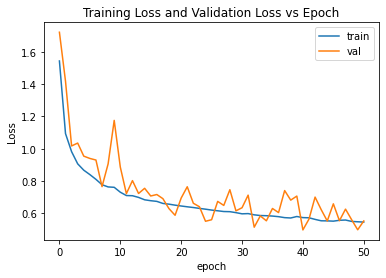

In [ ]:
# Plot the loss of training and validation against epoch
plt.plot(history1.history['loss'])
plt.plot(history1.history['val_loss'])
plt.title('Training Loss and Validation Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Above graph Loss vs Epoch shows that Loss of validation set is slight higher than loss of training set in 51 epoch.

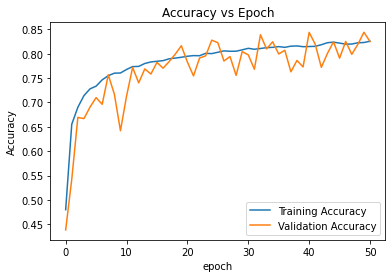

In [ ]:
# Plot the accuracy of training and validation against epoch
plt.plot(history1.history['accuracy'])
plt.plot(history1.history['val_accuracy'])
plt.title('Accuracy vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
plt.show()

Above graph Accuracy vs Epoch shows that accuracy of training set (0.8281) and test set(0.8248) almost same. It shows that there is no overfit in this model. 

In [ ]:
# Evaluate the model for training set
model1_train_score = model1.evaluate(scaledXtrain,y_train)

model_name.append('Optimized Model 1')
train_score.append(model1_train_score[1])
train_loss.append(model1_train_score[0])

1313/1313 [==============================] - 5s 3ms/step - loss: 0.4466 - accuracy: 0.8579


In [ ]:
# Evaluate the model for validation set
model1_val_score = model1.evaluate(scaledXval,y_val)

val_score.append(model1_val_score[1])
val_loss.append(model1_val_score[0])

1875/1875 [==============================] - 6s 3ms/step - loss: 0.4966 - accuracy: 0.8438


In [ ]:
# Evaluate the model for test set
model1_test_score = model1.evaluate(scaledXtest,y_test)

test_score.append(model1_test_score[1])
test_loss.append(model1_test_score[0])

563/563 [==============================] - 2s 3ms/step - loss: 0.6133 - accuracy: 0.8108


In [ ]:
# Predict the class for test set
mod1_preds = model1.predict(scaledXtest)

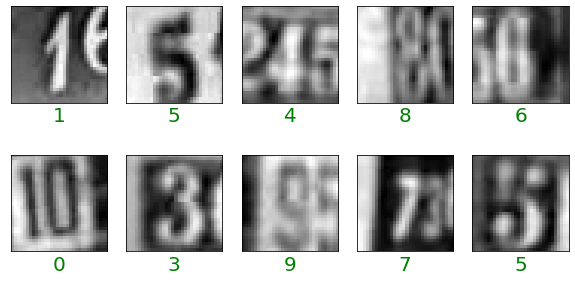

In [ ]:
# Plot the predicted target class randomly
show_random_examples(scaledXtest,y_test.argmax(axis = 1),mod1_preds.argmax(axis = 1))

In [ ]:
prediction_clf = (mod1_preds > 0.5)
print(classification_report(y_test, prediction_clf))

              precision    recall  f1-score   support

           0       0.94      0.75      0.83      1814
           1       0.88      0.79      0.84      1828
           2       0.89      0.78      0.83      1803
           3       0.86      0.71      0.78      1719
           4       0.92      0.80      0.86      1812
           5       0.88      0.74      0.80      1768
           6       0.86      0.78      0.82      1832
           7       0.89      0.81      0.85      1808
           8       0.85      0.71      0.77      1812
           9       0.86      0.76      0.80      1804

   micro avg       0.88      0.76      0.82     18000
   macro avg       0.88      0.76      0.82     18000
weighted avg       0.88      0.76      0.82     18000
 samples avg       0.76      0.76      0.76     18000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Observation:**<br>
As part of Optimization, below hyper parameters are used in above model.<br>
- Number of hidden layers: 3<br> 
- Number of neurons in First hidden layer: 100<br>
- Number of neurons in Second hidden layer: 200<br>
- Number of neurons in Third hidden layer: 100<br>
- Number of Dropout layers: 3 (with rate 0.03)<br>
- Activation function in hidden layers: Relu<br>
- Number of BathNormalization layers: 2<br>
- Optimizer: Adam<br>
- Batch Size: 120<br>
- Number of Epoch:200

Find below the observations from this model with above hyper parameters.
- The loss is very high in first epoch. It is drastically reduced in last epoch.
- Training stopped at 51 epoch since the loss is not decreasing consecutively 10 times.
- Above graph Loss vs Epoch shows that Loss of validation set is slight higher than loss of training set in 51 epoch.
- Above graph Accuracy vs Epoch shows that accuracy of training set (0.8281) and test set(0.8248) almost same.
- In model evaluation, accuracy of training set is 0.85 which is slight higher than accuracy of validation set (0.84) and test set(0.81). Loss of training set is less than loss of validation and test set.
- In the classification report, F1-Score is more than 80% for all target class except digit 3 and 8. Misclassification is very less for digit 4 when compare to other digits. There is 23% misclassification for digit 8.
- From above observations, there is slight difference in training accuracy and validation set accuracy. However accuracy of test set is 0.8108 which is good.
- It is good model. 

### Optimized Model 2

In [ ]:
# Initialize the model
model2 = tf.keras.Sequential()

# Add input layer
model2.add(tf.keras.Input(shape=(1024)))

# Initilaize the weights
initializer = tf.keras.initializers.HeUniform(seed=7)

# Add hidden layer with relu activation funcation
model2.add(Dense(300,activation='relu', kernel_initializer=initializer))
model2.add(Dropout(0.03)) # Add dropout layer

model2.add(Dense(100,activation='relu'))
model2.add(Dropout(0.03))


model2.add(Dense(50,activation='relu'))
model2.add(Dropout(0.03))

# Add output layer with softmax activation function as it is multiclass classification
model2.add(Dense(10,activation='softmax'))

In [ ]:
#Compile the model using categorical_crossentroy loss function as it is multiclass classification
optimizers = tf.keras.optimizers.Adam(learning_rate=0.0001)
model2.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
history2 = model2.fit(scaledXtrain, y_train,
          validation_data=(scaledXval, y_val), 
          epochs=300,
          batch_size = 150,
          verbose=1,
          callbacks= [callback]
         )

Epoch 1/300
280/280 [==============================] - 3s 9ms/step - loss: 2.3011 - accuracy: 0.1249 - val_loss: 2.2181 - val_accuracy: 0.2522
Epoch 2/300
280/280 [==============================] - 2s 7ms/step - loss: 2.1804 - accuracy: 0.2580 - val_loss: 1.9409 - val_accuracy: 0.4110
Epoch 3/300
280/280 [==============================] - 2s 7ms/step - loss: 1.8857 - accuracy: 0.3928 - val_loss: 1.6094 - val_accuracy: 0.5349
Epoch 4/300
280/280 [==============================] - 2s 8ms/step - loss: 1.6018 - accuracy: 0.4965 - val_loss: 1.4127 - val_accuracy: 0.5926
Epoch 5/300
280/280 [==============================] - 2s 7ms/step - loss: 1.4427 - accuracy: 0.5479 - val_loss: 1.2929 - val_accuracy: 0.6238
Epoch 6/300
280/280 [==============================] - 2s 7ms/step - loss: 1.3291 - accuracy: 0.5893 - val_loss: 1.2268 - val_accuracy: 0.6308
Epoch 7/300
280/280 [==============================] - 2s 7ms/step - loss: 1.2619 - accuracy: 0.6084 - val_loss: 1.1468 - val_accuracy: 0.6637

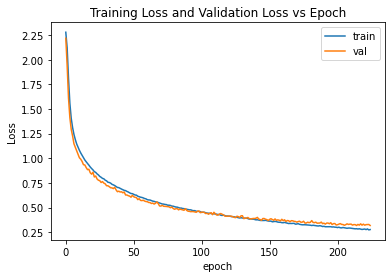

In [ ]:
# Plot the loss of training and validation against epoch
plt.plot(history2.history['loss'])
plt.plot(history2.history['val_loss'])
plt.title('Training Loss and Validation Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Above graph Loss vs Epoch shows that Loss of validation set is slight higher than loss of training set in 225 epoch.

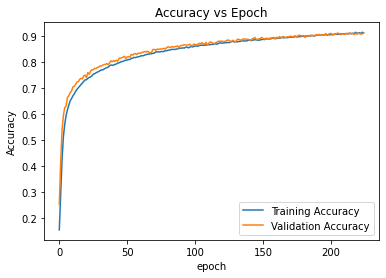

In [ ]:
# Plot the accuracy of training and validation against epoch
plt.plot(history2.history['accuracy'])
plt.plot(history2.history['val_accuracy'])
plt.title('Accuracy vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
plt.show()

Above graph Accuracy vs Epoch shows that accuracy of training set (0.9121) is very close to validation set(0.9115) accuracy. It shows that there is no overfit in this model.

In [ ]:
# Evaluate the model for training set
model2_train_score = model2.evaluate(scaledXtrain,y_train)

model_name.append("Optimized Model 2")
train_score.append(model2_train_score[1])
train_loss.append(model2_train_score[0])

1313/1313 [==============================] - 4s 3ms/step - loss: 0.2156 - accuracy: 0.9381


In [ ]:
# Evaluate the model for validation set
model2_val_score = model2.evaluate(scaledXval,y_val)

val_score.append(model2_val_score[1])
val_loss.append(model2_val_score[0])

1875/1875 [==============================] - 6s 3ms/step - loss: 0.3178 - accuracy: 0.9114


In [ ]:
# Evaluate the model for test set
model2_test_score = model2.evaluate(scaledXtest,y_test)

test_score.append(model2_test_score[1])
test_loss.append(model2_test_score[0])

563/563 [==============================] - 2s 3ms/step - loss: 0.5563 - accuracy: 0.8489


In [ ]:
# Predict the target class for test set
mod2_preds = model2.predict(scaledXtest)

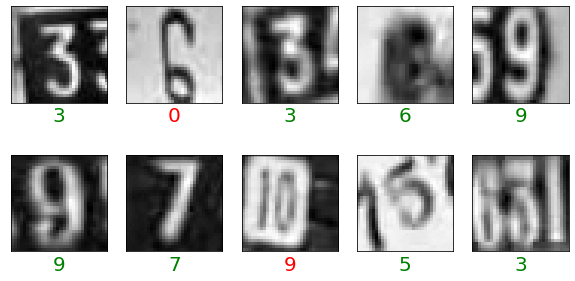

In [ ]:
# Plot the predicted target class randomly
show_random_examples(scaledXtest,y_test.argmax(axis = 1),mod2_preds.argmax(axis = 1))

In [ ]:
prediction_clf = (mod2_preds > 0.5)
print(classification_report(y_test, prediction_clf))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1814
           1       0.86      0.85      0.86      1828
           2       0.91      0.86      0.88      1803
           3       0.84      0.79      0.81      1719
           4       0.90      0.87      0.88      1812
           5       0.88      0.81      0.84      1768
           6       0.86      0.84      0.85      1832
           7       0.93      0.85      0.89      1808
           8       0.89      0.77      0.82      1812
           9       0.91      0.77      0.83      1804

   micro avg       0.89      0.83      0.86     18000
   macro avg       0.89      0.83      0.86     18000
weighted avg       0.89      0.83      0.86     18000
 samples avg       0.83      0.83      0.83     18000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Observation:**<br>
As part of Optimization, below hyper parameters are used in above model.<br>
- Number of hidden layers: 3<br> 
- Number of neurons in First hidden layer: 300<br>
- Number of neurons in Second hidden layer: 100<br>
- Number of neurons in Third hidden layer: 50<br>
- Number of Dropout layers: 3 (with rate 0.03)<br>
- Activation function in hidden layers: Relu<br>
- Number of BathNormalization layers: No BatchNormalization layer
- Optimizer: Adam with learning rate = 0.0001<br>
- Batch Size: 150<br>
- Number of Epoch:300

Find below the observations from this model with above hyper parameters.
- The loss is very high in first epoch. It is drastically reduced in last epoch.
- Training stopped at 225 epoch since the loss is not decreasing consecutively 10 times.
- Above graph Loss vs Epoch shows that Loss of validation set is slight higher than loss of training set in 225 epoch.
- Above graph Accuracy vs Epoch shows that accuracy of training set (0.9121) is very close to test set(0.9115) accuracy.
- In model evaluation, accuracy of training set is 0.93 which is slight higher than accuracy of validation set (0.91).  Accuracy of test set is 0.8489. Loss of training set is less than loss of validation and test set.
- In the classification report, F1-Score is more than 80% for all target class. Misclassification is very less for digit 7, 0 and 2 when compare to other digits. There is 19% misclassification for digit 3.
- From above observations, training accuracy is very close to validation set accuracy and test set accuracy is <b>0.8489<b> which is <b>higher than accuracy of Base Model and Optimized Model 1<b>.
- It is good fit model.

### Optimized Model 3

In [ ]:
# Initialize the model
model3 = tf.keras.Sequential()

model3.add(tf.keras.Input(shape=(1024)))

# Initilaize the weights
initializer = tf.keras.initializers.HeUniform(seed=7)

# Add hidden layer with relu activation function
model3.add(Dense(300,activation='relu', kernel_initializer=initializer))
model3.add(Dropout(0.03))

model3.add(Dense(100,activation='relu'))
model3.add(Dropout(0.03))

model3.add(Dense(50,activation='relu'))
model3.add(Dropout(0.03))

# Add output layer with softmax activation function as it is multiclass classifcation
model3.add(Dense(10,activation='softmax'))

In [ ]:
#Compile the model using categorical_crossentroy loss function as it is multiclass classification
optimizers = tf.keras.optimizers.SGD(learning_rate=0.0001, momentum=0.98, nesterov=True)
model3.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
history3 = model3.fit(scaledXtrain, y_train,
          validation_data=(scaledXval, y_val), 
          epochs=600,
          batch_size = 150,
          verbose=1,
          callbacks= [callback]
         )

Epoch 1/600
280/280 [==============================] - 3s 8ms/step - loss: 2.3526 - accuracy: 0.1026 - val_loss: 2.2967 - val_accuracy: 0.1184
Epoch 2/600
280/280 [==============================] - 2s 7ms/step - loss: 2.2991 - accuracy: 0.1159 - val_loss: 2.2897 - val_accuracy: 0.1436
Epoch 3/600
280/280 [==============================] - 2s 7ms/step - loss: 2.2918 - accuracy: 0.1280 - val_loss: 2.2830 - val_accuracy: 0.1578
Epoch 4/600
280/280 [==============================] - 2s 7ms/step - loss: 2.2856 - accuracy: 0.1398 - val_loss: 2.2755 - val_accuracy: 0.1836
Epoch 5/600
280/280 [==============================] - 2s 7ms/step - loss: 2.2786 - accuracy: 0.1556 - val_loss: 2.2659 - val_accuracy: 0.1946
Epoch 6/600
280/280 [==============================] - 2s 7ms/step - loss: 2.2693 - accuracy: 0.1690 - val_loss: 2.2556 - val_accuracy: 0.2054
Epoch 7/600
280/280 [==============================] - 2s 8ms/step - loss: 2.2588 - accuracy: 0.1856 - val_loss: 2.2429 - val_accuracy: 0.2337

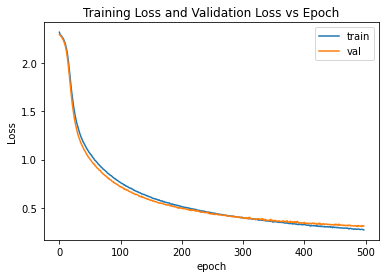

In [ ]:
# Plot the loss of training and validation against epoch
plt.plot(history3.history['loss'])
plt.plot(history3.history['val_loss'])
plt.title('Training Loss and Validation Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Above graph Loss vs Epoch shows that Loss of validation set is slight higher than loss of training set in 498 epoch.

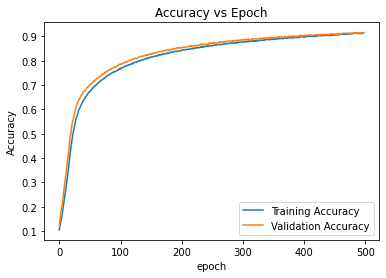

In [ ]:
# Plot the accuracy of training and validation against epoch
plt.plot(history3.history['accuracy'])
plt.plot(history3.history['val_accuracy'])
plt.title('Accuracy vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
plt.show()

- Above graph Accuracy vs Epoch shows that accuracy of training set (0.9159) is very close to test set(0.9139) accuracy.

In [ ]:
# Evaluate the model for training set
model3_train_score = model3.evaluate(scaledXtrain,y_train)

model_name.append("Optimized Model 3")
train_score.append(model3_train_score[1])
train_loss.append(model3_train_score[0])

1313/1313 [==============================] - 5s 3ms/step - loss: 0.2022 - accuracy: 0.9442


In [ ]:
# Evaluate the model for validation set
model3_val_score = model3.evaluate(scaledXval,y_val)

val_score.append(model3_val_score[1])
val_loss.append(model3_val_score[0])

1875/1875 [==============================] - 6s 3ms/step - loss: 0.3054 - accuracy: 0.9172


In [ ]:
# Evaluate the model for test set
model3_test_score = model3.evaluate(scaledXtest,y_test)

test_score.append(model3_test_score[1])
test_loss.append(model3_test_score[0])

563/563 [==============================] - 2s 3ms/step - loss: 0.5463 - accuracy: 0.8543


In [ ]:
# Predict the target class for test set
mod3_preds = model3.predict(scaledXtest)

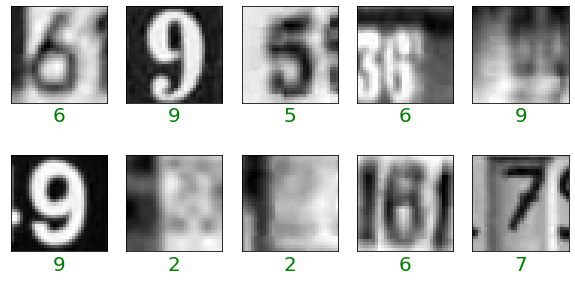

In [ ]:
# Plot the predicted target class randomly
show_random_examples(scaledXtest,y_test.argmax(axis = 1),mod3_preds.argmax(axis = 1))

In [ ]:
prediction_clf = (mod3_preds > 0.5)
print(classification_report(y_test, prediction_clf))

              precision    recall  f1-score   support

           0       0.91      0.87      0.89      1814
           1       0.91      0.82      0.86      1828
           2       0.93      0.85      0.89      1803
           3       0.82      0.81      0.81      1719
           4       0.91      0.86      0.89      1812
           5       0.87      0.83      0.85      1768
           6       0.90      0.82      0.86      1832
           7       0.92      0.86      0.89      1808
           8       0.88      0.80      0.84      1812
           9       0.89      0.80      0.84      1804

   micro avg       0.89      0.83      0.86     18000
   macro avg       0.89      0.83      0.86     18000
weighted avg       0.89      0.83      0.86     18000
 samples avg       0.83      0.83      0.83     18000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Observation:**<br>
As part of Optimization, below hyper parameters are used in above model.<br>
- Number of hidden layers: 3<br> 
- Number of neurons in First hidden layer: 300<br>
- Number of neurons in Second hidden layer: 100<br>
- Number of neurons in Third hidden layer: 50<br>
- Number of Dropout layers: 3 (with rate 0.03)<br>
- Activation function in hidden layers: Relu<br>
- Number of BathNormalization layers: No BatchNormalization layer
- Optimizer: SGD with learning rate = 0.0001, momentum=0.98 and nesterov=True<br>
- Batch Size: 150<br>
- Number of Epoch:600

Find below the observations from this model with above hyper parameters.
- The loss is very high in first epoch. It is drastically reduced in last epoch.
- Training stopped at 498 epoch since the loss is not decreasing consecutively 10 times.
- Above graph Loss vs Epoch shows that Loss of validation set is slight higher than loss of training set in 498 epoch.
- Above graph Accuracy vs Epoch shows that accuracy of training set (0.9159) is very close to test set(0.9139) accuracy.
- In model evaluation, accuracy of training set is 0.94 which is slight higher than accuracy of validation set (0.91).  Accuracy of test set is 0.8543. Loss of training set is less than loss of validation and test set.
- In the classification report, F1-Score is more than 80% for all target class. Misclassification is very less for digit 7, 0 and 2 when compare to other digits. There is 19% misclassification for digit 3 which is the highest misclassification rate in this model.
- From above observations, small difference between training accuracy and validation accuracy in model evaluation and test set accuracy is <b>0.8543 which is higher than accuracy of Base Model, Optimized Model 1 and Optimized Model 2.<b>
- It is good fit model.

### Optimized Model 4

In [ ]:
# Initialize the model
model4 = tf.keras.Sequential()

# Add the input layer
model4.add(tf.keras.Input(shape=(1024)))

# Initilaize the weights
initializer = tf.keras.initializers.HeUniform(seed=7)

# Add the hidden layer with relu activation function
model4.add(Dense(300, activation='relu', kernel_initializer=initializer))
model4.add(Dropout(0.03)) 

model4.add(Dense(100, activation='relu'))
model4.add(Dropout(0.03))

model4.add(Dense(50, activation='relu'))
model4.add(Dropout(0.03))

# Add the output layer with softmax activation function as it is multiclass classification
model4.add(Dense(10,activation='softmax'))

In [ ]:
#Compile the model using categorical_crossentroy loss function as it is multiclass classification
optimizers = tf.keras.optimizers.Adagrad(learning_rate=0.0001, initial_accumulator_value=0.01)
model4.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
history4 = model4.fit(scaledXtrain, y_train,
          validation_data=(scaledXval, y_val), 
          epochs=650,
          batch_size = 150,
          verbose=1,
          callbacks= [callback]
         )

Epoch 1/650
280/280 [==============================] - 3s 8ms/step - loss: 2.3445 - accuracy: 0.0987 - val_loss: 2.3052 - val_accuracy: 0.1048
Epoch 2/650
280/280 [==============================] - 2s 8ms/step - loss: 2.3079 - accuracy: 0.1061 - val_loss: 2.3014 - val_accuracy: 0.1119
Epoch 3/650
280/280 [==============================] - 2s 8ms/step - loss: 2.3048 - accuracy: 0.1093 - val_loss: 2.2994 - val_accuracy: 0.1179
Epoch 4/650
280/280 [==============================] - 2s 8ms/step - loss: 2.3030 - accuracy: 0.1111 - val_loss: 2.2979 - val_accuracy: 0.1228
Epoch 5/650
280/280 [==============================] - 2s 8ms/step - loss: 2.3023 - accuracy: 0.1097 - val_loss: 2.2967 - val_accuracy: 0.1253
Epoch 6/650
280/280 [==============================] - 2s 7ms/step - loss: 2.3003 - accuracy: 0.1160 - val_loss: 2.2957 - val_accuracy: 0.1268
Epoch 7/650
280/280 [==============================] - 2s 8ms/step - loss: 2.2990 - accuracy: 0.1135 - val_loss: 2.2949 - val_accuracy: 0.1282

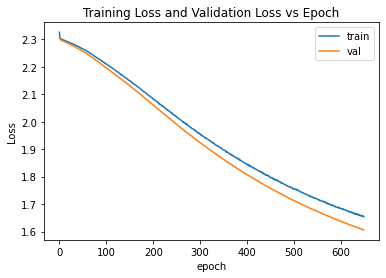

In [ ]:
# Plot the loss of training and validation against epoch
plt.plot(history4.history['loss'])
plt.plot(history4.history['val_loss'])
plt.title('Training Loss and Validation Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Above graph Loss vs Epoch shows that Loss of validation set is less than loss of training set in 650 epoch.

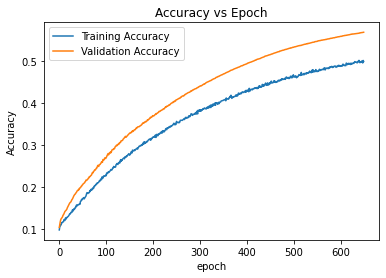

In [ ]:
# Plot the accuracy of training and validation against epoch
plt.plot(history4.history['accuracy'])
plt.plot(history4.history['val_accuracy'])
plt.title('Accuracy vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
plt.show()

Above graph Accuracy vs Epoch shows that accuracy of training set (0.4964) is less than validation set(0.5675) accuracy.

In [ ]:
# Evaluate the model for training set
model4_train_score = model4.evaluate(scaledXtrain,y_train)

model_name.append("Optimized Model 4")
train_score.append(model4_train_score[1])
train_loss.append(model4_train_score[0])

1313/1313 [==============================] - 4s 3ms/step - loss: 1.6079 - accuracy: 0.5662


In [ ]:
# Evaluate the model for validation set
model4_val_score = model4.evaluate(scaledXval,y_val)

val_score.append(model4_val_score[1])
val_loss.append(model4_val_score[0])

1875/1875 [==============================] - 6s 3ms/step - loss: 1.6061 - accuracy: 0.5675


In [ ]:
# Evaluate the model for test set
model4_test_score = model4.evaluate(scaledXtest,y_test)

test_score.append(model4_test_score[1])
test_loss.append(model4_test_score[0])

563/563 [==============================] - 2s 3ms/step - loss: 1.6018 - accuracy: 0.5704


In [ ]:
# Predict the target class for test set
mod4_preds = model4.predict(scaledXtest)

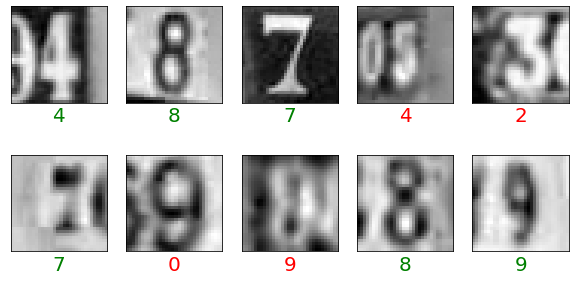

In [ ]:
# Plot the predicted target class randomly
show_random_examples(scaledXtest,y_test.argmax(axis = 1),mod4_preds.argmax(axis = 1))

In [ ]:
prediction_clf = (mod4_preds > 0.5)
print(classification_report(y_test, prediction_clf))

              precision    recall  f1-score   support

           0       0.93      0.07      0.13      1814
           1       0.89      0.14      0.25      1828
           2       1.00      0.02      0.04      1803
           3       0.86      0.01      0.02      1719
           4       0.95      0.29      0.45      1812
           5       1.00      0.01      0.02      1768
           6       0.92      0.06      0.10      1832
           7       0.97      0.10      0.18      1808
           8       0.88      0.01      0.02      1812
           9       0.93      0.01      0.03      1804

   micro avg       0.93      0.07      0.14     18000
   macro avg       0.93      0.07      0.12     18000
weighted avg       0.93      0.07      0.12     18000
 samples avg       0.07      0.07      0.07     18000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Observation:**<br>
As part of Optimization, below hyper parameters are used in above model.<br>
- Number of hidden layers: 3<br> 
- Number of neurons in First hidden layer: 300<br>
- Number of neurons in Second hidden layer: 100<br>
- Number of neurons in Third hidden layer: 50<br>
- Number of Dropout layers: 3 (with rate 0.03)<br>
- Activation function in hidden layers: Relu<br>
- Number of BathNormalization layers: No BatchNormalization layer
- Optimizer: Adagrad with learning rate = 0.0001, initial_accumulator_value=0.01<br>
- Batch Size: 150<br>
- Number of Epoch:650

Find below the observations from this model with above hyper parameters.
- The loss is very high in first epoch. It is drastically reduced in last epoch.
- Training stopped at 498 epoch since the loss is not decreasing consecutively 10 times.
- Above graph Loss vs Epoch shows that Loss of validation set is less than loss of training set in 650 epoch.
- Above graph Accuracy vs Epoch shows that accuracy of training set (0.4964) is less than validation set(0.5675) accuracy.
- In model evaluation, accuracy of training set and validation set is 0.56.  Accuracy of test set is 0.5704. Loss of training set is very close to validation and test set.
- In the classification report, F1-Score is very less for all target class. F1 score is 0.45 for digit 4. It is highest score when compare to other digits in this model.
- From above observations, training accuracy (0.56), validation accuracy ((0.56), test accuracy(0.5704) and F1 Score are very less when compared to other models (Base Model, Optimized Model 1, Optimized Model 2 and Optimized Model 3).
- It is not good model.

### Optimized Model 5

In [ ]:
# Initialize the model
model5 = tf.keras.Sequential()

# Add the input layer
model5.add(tf.keras.Input(shape=(1024)))

# Initilaize the weights
initializer = tf.keras.initializers.HeUniform(seed=7)

# Add the hidden layers with LeakyRelu function
model5.add(Dense(300, kernel_initializer=initializer))
model5.add(LeakyReLU(alpha=0.05))
model5.add(Dropout(0.03)) # Add the dropout layer

model5.add(Dense(100))
model5.add(LeakyReLU(alpha=0.05))
model5.add(Dropout(0.03))

model5.add(Dense(50))
model5.add(LeakyReLU(alpha=0.05))
model5.add(Dropout(0.03))

# Add the output layer with softmax function
model5.add(Dense(10,activation='softmax'))

In [ ]:
#Compile the model using categorical_crossentroy loss function as it is multiclass classification
optimizers = tf.keras.optimizers.Adam(learning_rate=0.0001)
model5.compile(optimizer=optimizers, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Train the model
callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, mode='min')
history5 = model5.fit(scaledXtrain, y_train,
          validation_data=(scaledXval, y_val), 
          epochs=600,
          batch_size = 150,
          verbose=1,
          callbacks= [callback]
         )

Epoch 1/600
280/280 [==============================] - 3s 8ms/step - loss: 2.2997 - accuracy: 0.1253 - val_loss: 2.2140 - val_accuracy: 0.2580
Epoch 2/600
280/280 [==============================] - 2s 8ms/step - loss: 2.1525 - accuracy: 0.2779 - val_loss: 1.8513 - val_accuracy: 0.4242
Epoch 3/600
280/280 [==============================] - 2s 7ms/step - loss: 1.7825 - accuracy: 0.4244 - val_loss: 1.5325 - val_accuracy: 0.5458
Epoch 4/600
280/280 [==============================] - 2s 8ms/step - loss: 1.5212 - accuracy: 0.5189 - val_loss: 1.3644 - val_accuracy: 0.5875
Epoch 5/600
280/280 [==============================] - 2s 7ms/step - loss: 1.3923 - accuracy: 0.5628 - val_loss: 1.2739 - val_accuracy: 0.6111
Epoch 6/600
280/280 [==============================] - 2s 8ms/step - loss: 1.3152 - accuracy: 0.5903 - val_loss: 1.2268 - val_accuracy: 0.6288
Epoch 7/600
280/280 [==============================] - 2s 8ms/step - loss: 1.2421 - accuracy: 0.6131 - val_loss: 1.1556 - val_accuracy: 0.6545

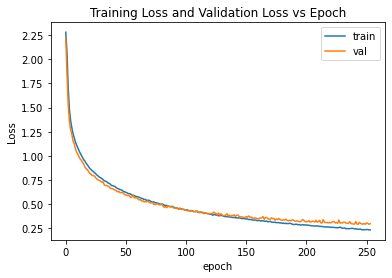

In [ ]:
# Plot the loss of training and validation against epoch
plt.plot(history5.history['loss'])
plt.plot(history5.history['val_loss'])
plt.title('Training Loss and Validation Loss vs Epoch')
plt.ylabel('Loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

Above graph Loss vs Epoch shows that Loss of validation set is slight higher than loss of training set in 254 epoch

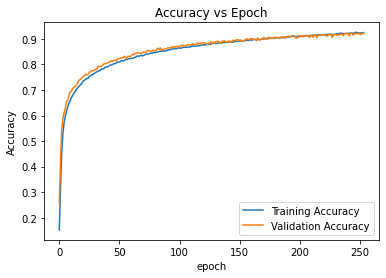

In [ ]:
# Plot the accuracy of training and validation against epoch
plt.plot(history5.history['accuracy'])
plt.plot(history5.history['val_accuracy'])
plt.title('Accuracy vs Epoch')
plt.ylabel('Accuracy')
plt.xlabel('epoch')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='best')
plt.show()

Above graph Accuracy vs Epoch shows that accuracy of training set (0.9281) is very close to validation set(0.9201) accuracy.

In [ ]:
# Evaluate the model for training set
model5_train_score = model5.evaluate(scaledXtrain,y_train)

model_name.append("Optimized Model 5")
train_score.append(model5_train_score[1])
train_loss.append(model5_train_score[0])

1313/1313 [==============================] - 4s 3ms/step - loss: 0.1700 - accuracy: 0.9531


In [ ]:
# Evaluate the model for validation set
model5_val_score = model5.evaluate(scaledXval,y_val)

val_score.append(model5_val_score[1])
val_loss.append(model5_val_score[0])

1875/1875 [==============================] - 6s 3ms/step - loss: 0.2922 - accuracy: 0.9237


In [ ]:
# Evaluate the model for test set
model5_test_score = model5.evaluate(scaledXtest,y_test)

test_score.append(model5_test_score[1])
test_loss.append(model5_test_score[0])

563/563 [==============================] - 2s 3ms/step - loss: 0.5773 - accuracy: 0.8548


In [ ]:
# Predict the target class for test set
mod5_preds = model5.predict(scaledXtest)

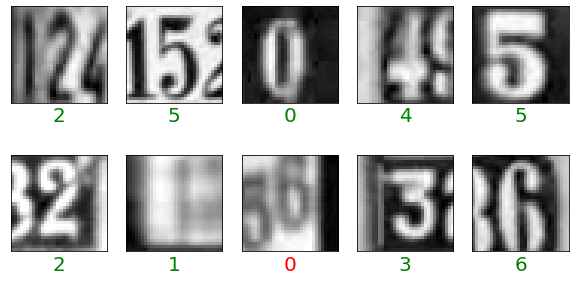

In [ ]:
# Plot the predicted target class randomly
show_random_examples(scaledXtest,y_test.argmax(axis = 1),mod5_preds.argmax(axis = 1))

In [ ]:
prediction_clf = (mod5_preds > 0.5)
print(classification_report(y_test, prediction_clf))

              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1814
           1       0.90      0.83      0.86      1828
           2       0.93      0.84      0.88      1803
           3       0.85      0.78      0.82      1719
           4       0.90      0.88      0.89      1812
           5       0.89      0.80      0.84      1768
           6       0.89      0.82      0.85      1832
           7       0.91      0.88      0.90      1808
           8       0.85      0.80      0.83      1812
           9       0.86      0.83      0.84      1804

   micro avg       0.89      0.83      0.86     18000
   macro avg       0.89      0.83      0.86     18000
weighted avg       0.89      0.83      0.86     18000
 samples avg       0.83      0.83      0.83     18000



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


**Observation:**<br>
As part of Optimization, below hyper parameters are used in above model.<br>
- Number of hidden layers: 3<br> 
- Number of neurons in First hidden layer: 300<br>
- Number of neurons in Second hidden layer: 100<br>
- Number of neurons in Third hidden layer: 50<br>
- Number of Dropout layers: 3 (with rate 0.03)<br>
- Activation function in hidden layers: LeakyRelu with alpha=0.05<br>
- Number of BathNormalization layers: No BatchNormalization layer
- Optimizer: Adam with learning rate = 0.0001<br>
- Batch Size: 150<br>
- Number of Epoch:600

Find below the observations from this model with above hyper parameters.
- The loss is very high in first epoch. It is drastically reduced in last epoch.
- Training stopped at 254 epoch since the loss is not decreasing consecutively 10 times.
- Above graph Loss vs Epoch shows that Loss of validation set is slight higher than loss of training set in 254 epoch.
- Above graph Accuracy vs Epoch shows that accuracy of training set (0.9281) is very close to validation set(0.9201) accuracy.
- In model evaluation, accuracy of training set is 0.95 which is higher than accuracy of validation set (0.92).  Accuracy of test set is 0.8548. Loss of training set is less than loss of validation and test set.
- In the classification report, F1-Score is more than 80% for all target class. Misclassification rate is very less for digit 7 when compare to other digits. There is 18% misclassification for digit 3 which is the highest misclassification rate in this model.
- From above observations, small difference between training accuracy and validation accuracy in model evaluation and test set accuracy is <b>0.8548 which is higher than accuracy of other models.<b>
- It is good fit model.

## Model Comparison

In [ ]:
dfscore = pd.DataFrame(data=[model_name, train_score, val_score, test_score], index=["Model","Training Score","Validation Score","Testing Score"])
dfscore.T

,Model,Training Score,Validation Score,Testing Score
0,Base Model,0.909881,0.88485,0.826444
1,Optimized Model 1,0.857905,0.843783,0.810833
2,Optimized Model 2,0.938143,0.911383,0.848944
3,Optimized Model 3,0.944214,0.91725,0.854333
4,Optimized Model 4,0.566214,0.567467,0.570389
5,Optimized Model 5,0.953143,0.92365,0.854833


In [ ]:
dfloss = pd.DataFrame(data=[model_name, train_loss, val_loss, test_loss], index=["Model","Training Loss","Validation Loss","Testing Loss"])
dfloss.T


,Model,Training Loss,Validation Loss,Testing Loss
0,Base Model,0.274489,0.394014,0.672908
1,Optimized Model 1,0.446566,0.496576,0.613263
2,Optimized Model 2,0.215585,0.317794,0.556283
3,Optimized Model 3,0.202188,0.305421,0.546298
4,Optimized Model 4,1.60789,1.60605,1.60177
5,Optimized Model 5,0.170038,0.292215,0.577295


**Take Away:**<br>
- Activation function with learning rate, Number of hidden layers, Number of nuerons, BatchNormalization layers, Dropout layers, Batch Size and Epoch are playing a key role in model performance. 
- Above model building, we got less accuracy with Adagrad activation function in Optimization Model 4 and loss also very high in this model. We got good accuracy for remaining models when we use Adam with very value in learning rate and SGD with momentum and high number of epoch.  


# End Project